In [24]:
import numpy as np
import sys
sys.path.insert(1,'./src/')
from models import ChemicalReactionNetwork
from matplotlib import pyplot as plt
from tqdm import tqdm
import corner

See [description of this notebook](./questions.md/#july-17th-non-abc)

In [25]:
species = 'A B C'.split()
reactions = [
    ({'A': 1}, {'B': 1}),
    ({'B': 1}, {'A': 1}),
    ({'B': 1}, {'C': 1}),
    ({'C': 1}, {'B': 1}),
]
kinetic_rates = np.array([2e-2,1e-1,1e-1,2e-2])*2
# some of the kinetic rates has to equal. 

model = ChemicalReactionNetwork(reactions, species, kinetic_rates)

X_init = np.array([10,20,30])

T = 30

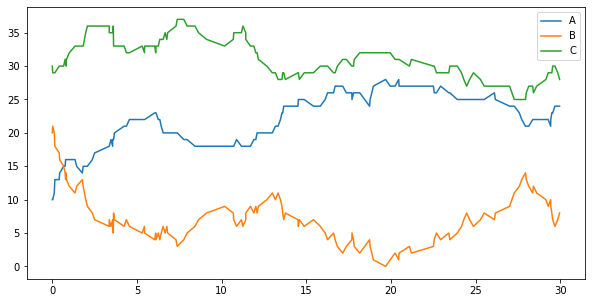

In [26]:
x,r,t = model.gilespie(X_init,T)
plt.figure(figsize=(10,5))
for i in range(3):
    plt.plot(t,x[:,i],label=species[i])
plt.legend();

the observables are only copy number of `B`, so our observation should be that:


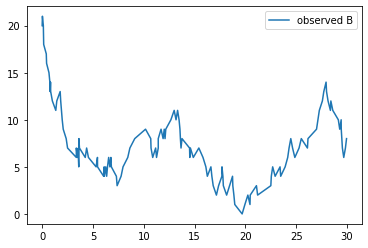

In [27]:
b = model.get_observation(t,x,'B').flatten()
plt.plot(t,b,label='observed B')
plt.legend();

TODO : maybe I can only take observations at specific times. 

Now, let's think what's in a state:

- reaction time $t_i$
- populations of the 3 species $a_i,b_i,c_i$

So the first step is to generate an initial state based on our observation. 

The observation provides for us the $t_i,a_i$. I will use a random number generator to generate an initial guess of $b_i, c_i$


In [28]:
def get_r(a,c):
    r = np.zeros(len(a)-1,dtype=int)
    
    diff_a = np.diff(a,1)
    diff_c = np.diff(c,1)
    r[diff_a==-1] = 0
    r[diff_a==1] = 1
    r[diff_c==1] = 2
    r[diff_c==-1] = 3
    
    return r

def log_likelihood(state):
    k,a,b,c = state
    r = get_r(a,c)
    X = np.array([a,b,c]).T
    return model.gilespie_exact_log_likelihood(k,X,r,t,T)
    # should this thing be modified a bit? as it is conditioned on fixing b and fixing t. 
    # No, it is still correct up to a constant. so it won't matter in MCMC. 

In [29]:
total_copy_number = np.sum(x[0])

def generate_initial_state(b,t,total_copy_number=total_copy_number):
    cond = True
    while cond:
        
        k = np.random.uniform(0,0.5,len(kinetic_rates)) + kinetic_rates
        c0 = np.random.randint(0,total_copy_number)
        a0 = total_copy_number - c0 - b[0]
        
        diff_b = np.diff(b,1) # this equals to '- diff_a - diff_c'
        diff_a = np.zeros(shape=diff_b.shape)
        # diff_c = np.zeros(0)
        
        for i,db in enumerate(diff_b):
            if np.random.uniform() < 0.5:
                diff_a[i] = -db
            # else:
                # diff_c[i] = db
        
        a = np.cumsum(np.insert(diff_a,0,a0))
        c = total_copy_number - a - b
        if np.any(b<0) or np.any(c<0):
            continue
        else: cond = (log_likelihood((k,a,b,c)) == -np.inf)
    initial_state = (k,a,b,c)
    return initial_state

In [32]:
initial_state = generate_initial_state(b,t)
k,a,b,c = initial_state
log_likelihood(initial_state)

-177.27480605822217

Text(0.5, 1.0, 'initial state')

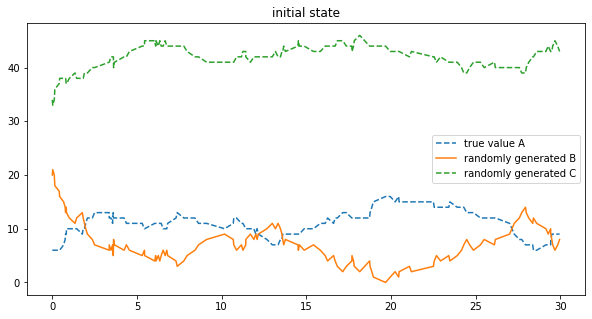

In [33]:
plt.figure(figsize=(10,5))
plt.plot(t,a,'--',label='change later A')
plt.plot(t,b,label='randomly generated B')
plt.plot(t,c, '--', label='randomly generated C')
plt.legend()
plt.title('initial state')

In [46]:
len(t)

143

In this particular partial implementation, the only things we can change are 
- kinetic rates
- interchanging reactions 2 and 3. i.e. $B \xLeftrightarrow[k_4]{k_3} C$
- the initial population of the $B,C$

In [34]:
def get_box(k, box_size):

    box = []
    volume = 1

    for t in k:
        lower = max(t-box_size, 0)
        upper = t+box_size
        box.append((lower, upper))
        volume *= (upper-lower)

    box = np.array(box).T

    return box, volume

def move_k(state, box_size=1e-2):
    k, a, b, c = state
    box, volume = get_box(k, box_size)
    new_k = np.random.uniform(*box)

    _, volume2 = get_box(new_k, box_size)

    return (new_k, a, b, c), np.log(volume/volume2)

def move_reaction(state):
    '''
    this is merged with moving the initial copy number.
    '''
    
    _, a, b, c = state
    r = get_r(a, c)

    if a[-1] == 0 and c[-1] == 0:
        print('not going to move at all')
        assert(0)
        
    while True:
        moving_index = np.random.randint(len(t))
        if moving_index == 0:
            # moving the initial copy number
            a_min = np.min(a)
            c_min = np.min(c)
            if a_min == 0 and c_min == 0:
                continue # cannot move the initial copy number
            elif a_min == 0 and c_min > 0:
                a = a + 1
                c = c - 1
                log_p = 0 # this is probably incorrect.
            elif a_min > 0 and c_min == 0:
                a = a - 1
                c = c + 1
                log_p = 0 # this is probably incorrect.
            else:
                if np.random.uniform() < 0.5:
                    a = a + 1
                    c = c - 1
                    log_p = 0
                else:
                    a = a - 1
                    c = c + 1
                    log_p = 0
            return (k,a,b,c),log_p
        
        a_min = np.min(a[moving_index-1:])
        c_min = np.min(c[moving_index-1:])
        reaction = r[moving_index-1]
        if a_min == 0 and c_min == 0:
            continue # cannot move the initial copy number
        elif a_min == 0 and c_min > 0 and reaction == 0:
            a = a + 1
            c = c - 1
            log_p = 0
            r[moving_index-1] = 3
        elif a_min > 0 and c_min == 0 and reaction == 3:
            a = a - 1
            c = c + 1
            log_p = 0 # this is probably incorrect.
            r[moving_index-1] = 0
        else:
            if reaction == 0:
                a = a + 1
                c = c - 1
                log_p = 0
                r[moving_index-1] = 3
            elif reaction == 1:
                a = a - 1
                c = c + 1
                log_p = 0
                r[moving_index-1] = 0
            elif reaction == 2:
                a = a + 1
                c = c - 1
                log_p = 0
                r[moving_index-1] = 1
            elif reaction == 3:
                a = a - 1
                c = c + 1
                log_p = 0
                r[moving_index-1] = 2
        
        return (k,a,b,c), log_p

moves = [move_k, move_reaction]

def move(state):
    if np.random.uniform() < 0.2:
        return moves[1](state)
    else:
        return moves[0](state)

def mcmc(initial_state, n):

    samples = [initial_state]
    if_accepted = []

    prev_log_pst = log_likelihood(initial_state)

    for i in tqdm(range(n), desc='sampling state space'):

        new_state, log_p = move(samples[-1])
        curr_log_pst = log_likelihood(new_state)
        log_acceptance = curr_log_pst - prev_log_pst + log_p
        if_accepted.append(log_acceptance >= 0 or np.log(
            np.random.uniform()) < log_acceptance)
        if if_accepted[-1]:
            samples.append(new_state)
            prev_log_pst = curr_log_pst
        else:
            samples.append(samples[-1])
    
    print('acceptance rate:', np.mean(if_accepted))
    return samples

In [35]:
pst_samples = mcmc(initial_state, n=400000)

sampling state space: 100%|██████████| 400000/400000 [29:51<00:00, 223.25it/s]

acceptance rate: 0.44933


In [36]:
pst_k = np.array([s[0] for s in pst_samples])

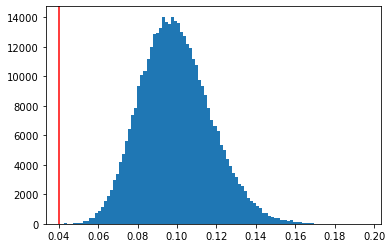

In [37]:
plt.hist( pst_k[1000:,0], bins = 100)
plt.axvline(kinetic_rates[0],c='r')
print()

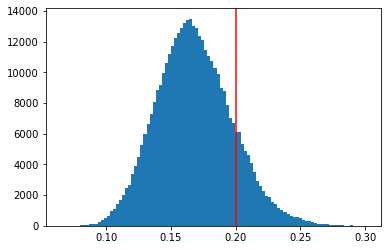

In [38]:
plt.hist( pst_k[1000:,1], bins = 100)
plt.axvline(kinetic_rates[1],c='r')
print()


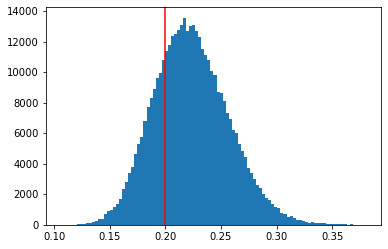

In [39]:
plt.hist(pst_k[1000:,2], bins = 100)
plt.axvline(kinetic_rates[2],c='r')

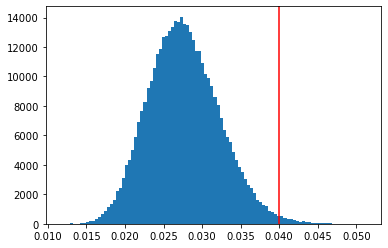

In [40]:
plt.hist(pst_k[1000:,3], bins = 100)
plt.axvline(kinetic_rates[3],c='r')

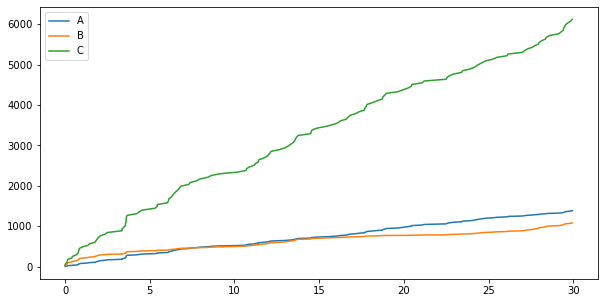

In [47]:
plt.figure(figsize=(10,5))
for i in range(3):
    plt.plot(t,np.sum(pst_samples[-1][i+1]),label=species[i])
plt.legend()

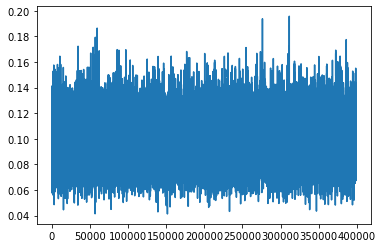

In [45]:
plt.plot(pst_k[1000:,0],label='k')

In [42]:
log_likelihood(pst_samples[-1])

-109.84122700746668

In [43]:
log_likelihood((kinetic_rates, x[:,0], x[:,1], x[:,2]))

-108.39845212516433

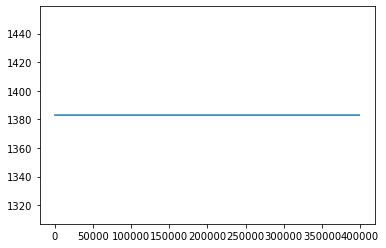

In [65]:
plt.plot([np.sum(i[1]) for i in pst_samples[1000:]])

try to do the example with only path move. 